In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install textstat

import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
import seaborn
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.7 MB/s eta 0:00:00


In [3]:
# Load your dataset
dataset = pd.read_csv("/content/drive/MyDrive/hate_speech.csv")

# Explore the data by displaying the first few rows
print(dataset.head())


   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  


In [4]:
# Adding text-length as a field in the dataset
dataset['text length'] = dataset['tweet'].apply(len)
print(dataset.head())


   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  text length  
0  !!! RT @mayasolovely: As a woman you shouldn't...          140  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...           85  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...          120  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...           62  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...          137  


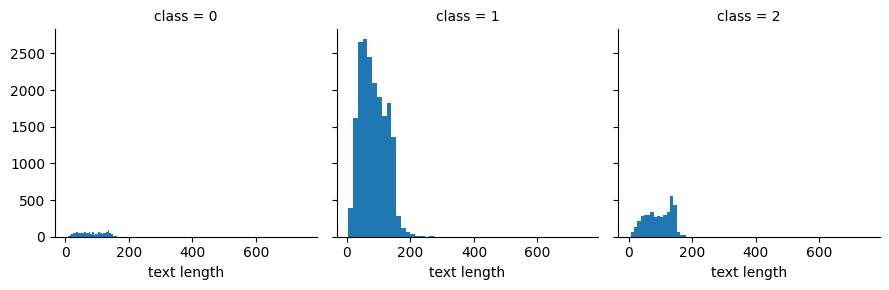

In [5]:
#Basic visualization of data using histograms
# FacetGrid- Multi-plot grid for plotting conditional relationships
import seaborn as sns
import matplotlib.pyplot as plt
graph = sns.FacetGrid(data=dataset, col='class')
graph.map(plt.hist, 'text length', bins=50)

<Axes: xlabel='class', ylabel='text length'>

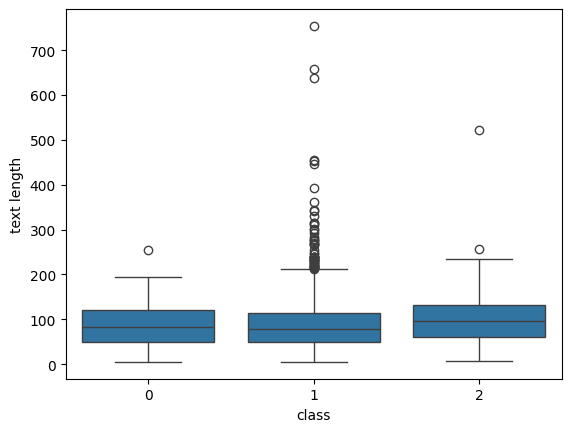

In [6]:
# Box-plot visvualization
sns.boxplot(x='class', y='text length', data=dataset)


<Axes: >

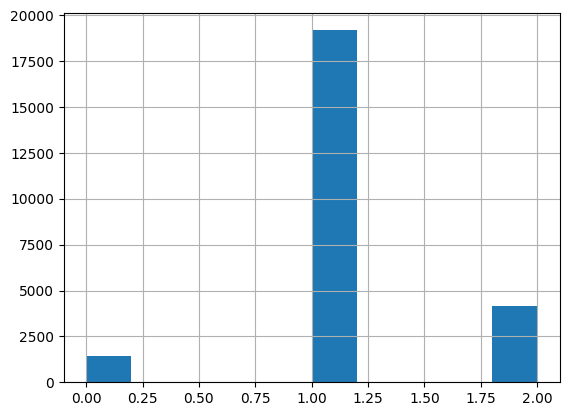

In [7]:
dataset['class'].hist()


In [8]:
# collecting only the tweets from the csv file into a variable name tweet
tweet=dataset.tweet


In [9]:

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Load stopwords
stopwords_list = stopwords.words("english")

# Extend stopwords to include other words used in Twitter such as retweet (rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords_list.extend(other_exclusions)

# Initialize the Porter stemmer
stemmer = PorterStemmer()

def preprocess(tweet):
    # Remove extra spaces
    tweet = re.sub(r'\s+', ' ', tweet)

    # Remove @name (mentions)
    tweet = re.sub(r'@[\w\-]+', '', tweet)

    # Remove links (URLs)
    tweet = re.sub(r'http[s]?://\S+', '', tweet)

    # Remove punctuation and numbers
    tweet = re.sub(r'[^a-zA-Z]', ' ', tweet)

    # Remove extra spaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()

    # Replace normal numbers with 'numbr'
    tweet = re.sub(r'\d+(\.\d+)?', 'numbr', tweet)

    # Convert to lowercase
    tweet = tweet.lower()

    # Tokenize the tweet
    tokens = tweet.split()

    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords_list]

    # Stem the tokens
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    # Join tokens back to a single string
    processed_tweet = ' '.join(stemmed_tokens)

    return processed_tweet

# Load your dataset, assuming it's in a CSV file
dataset = pd.read_csv("/content/drive/MyDrive/hate_speech.csv")

# Apply the preprocess function to each tweet in the dataset
dataset['processed_tweets'] = dataset['tweet'].apply(preprocess)

# Display the first 10 rows of the dataset with original and processed tweets
print(dataset[['tweet', 'processed_tweets']].head(10))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                               tweet  \
0  !!! RT @mayasolovely: As a woman you shouldn't...   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   
5  !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...   
6  !!!!!!"@__BrighterDays: I can not just sit up ...   
7  !!!!&#8220;@selfiequeenbri: cause I'm tired of...   
8  " &amp; you might not get ya bitch back &amp; ...   
9  " @rhythmixx_ :hobbies include: fighting Maria...   

                                    processed_tweets  
0  woman complain clean hous amp man alway take t...  
1  boy dat cold tyga dwn bad cuffin dat hoe st place  
2         dawg ever fuck bitch start cri confus shit  
3                                   look like tranni  
4     shit hear might true might faker bitch told ya  
5      shit blow claim faith somebodi still fuck hoe 

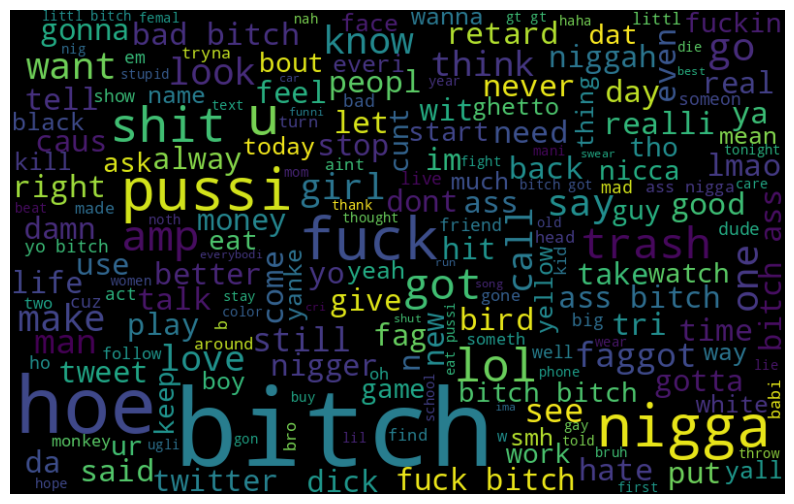

In [10]:
# visualizing which of the word is most commonly used in the twitter dataset
from wordcloud import WordCloud
# imshow-Display data as an image
# interpolation - https://matplotlib.org/3.2.1/gallery/images_contours_and_fields/interpolation_methods.html
all_words = ' '.join([text for text in dataset['processed_tweets'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
#random=0.30
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

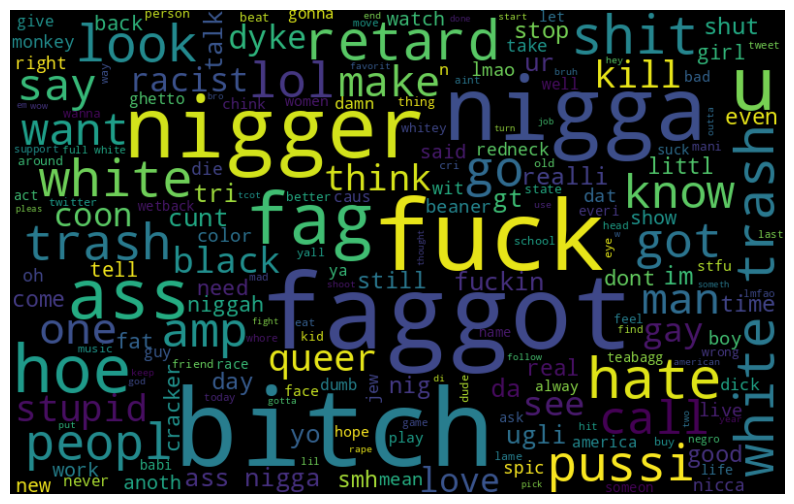

In [11]:
# visualizing which of the word is most commonly used for hatred speech
hatred_words = ' '.join([text for text in dataset['processed_tweets'][dataset['class'] == 0]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


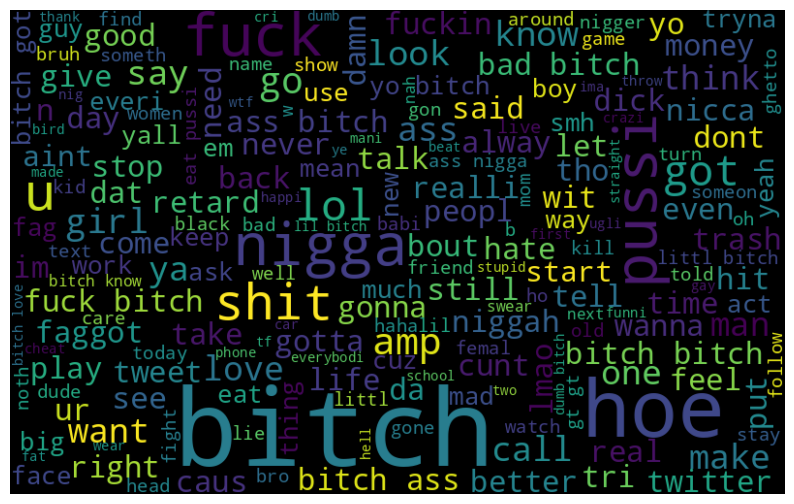

In [12]:
# visualizing which of the word is most commonly used for offensive speech
offensive_words = ' '.join([text for text in dataset['processed_tweets'][dataset['class'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(offensive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [13]:
#TF-IDF Features-F1
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(dataset['processed_tweets'] )
tfidf


<24783x6441 sparse matrix of type '<class 'numpy.float64'>'
	with 189577 stored elements in Compressed Sparse Row format>

In [14]:
nltk.download('vader_lexicon')
sentiment_analyzer = VS()
def count_tags(tweet_c):

    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', tweet_c)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def sentiment_analysis(tweet):
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    twitter_objs = count_tags(tweet)
    features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],twitter_objs[0], twitter_objs[1],
                twitter_objs[2]]
    #features = pandas.DataFrame(features)
    return features

def sentiment_analysis_array(tweets):
    features=[]
    for t in tweets:
        features.append(sentiment_analysis(t))
    return np.array(features)

final_features = sentiment_analysis_array(tweet)
#final_features

new_features = pd.DataFrame({'Neg':final_features[:,0],'Pos':final_features[:,1],'Neu':final_features[:,2],'Compound':final_features[:,3],
                            'url_tag':final_features[:,4],'mention_tag':final_features[:,5],'hash_tag':final_features[:,6]})
new_features


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,Neg,Pos,Neu,Compound,url_tag,mention_tag,hash_tag
0,0.000,0.120,0.880,0.4563,0.0,1.0,0.0
1,0.237,0.000,0.763,-0.6876,0.0,1.0,0.0
2,0.538,0.000,0.462,-0.9550,0.0,2.0,0.0
3,0.000,0.344,0.656,0.5673,0.0,2.0,0.0
4,0.249,0.081,0.669,-0.7762,0.0,1.0,1.0
...,...,...,...,...,...,...,...
24778,0.000,0.000,1.000,0.0000,0.0,3.0,3.0
24779,0.454,0.000,0.546,-0.8074,0.0,0.0,0.0
24780,0.000,0.219,0.781,0.4738,0.0,0.0,0.0
24781,0.573,0.000,0.427,-0.7717,0.0,0.0,0.0


In [15]:
# F2-Conctaenation of tf-idf scores and sentiment scores
tfidf_a = tfidf.toarray()
# Assuming final_features_1 is a 1D array or a list
# Reshape it to a 2D array with one column

# Concatenate the arrays
modelling_features = np.concatenate([tfidf_a, final_features], axis=1)


In [16]:
X = pd.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc1)

test_data = ["your", "list", "of", "custom", "text", "data"]
tfidf_array = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.45      0.26      0.33       290
           1       0.92      0.95      0.94      3832
           2       0.83      0.85      0.84       835

    accuracy                           0.89      4957
   macro avg       0.73      0.69      0.70      4957
weighted avg       0.88      0.89      0.88      4957

SVM, Accuracy Score: 0.8918700827113173


In [17]:
nltk.download('vader_lexicon')

# create doc2vec vector columns
# Initialize and train the model
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#The input for a Doc2Vec model should be a list of TaggedDocument(['list','of','word'], [TAG_001]).
#A good practice is using the indexes of sentences as the tags.
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(dataset["processed_tweets"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
# window- The maximum distance between the current and predicted word within a sentence.
# mincount-Ignores all words with total frequency lower than this.
# workers -Use these many worker threads to train the model
#  Training Model - distributed bag of words (PV-DBOW) is employed.
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

#infer_vector - Infer a vector for given post-bulk training document.
# Syntax- infer_vector(doc_words, alpha=None, min_alpha=None, epochs=None, steps=None)
# doc_words-A document for which the vector representation will be inferred.

# transform each document into a vector data
doc2vec_df = dataset["processed_tweets"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
doc2vec_df


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,-0.065078,0.025938,-0.042804,-0.161644,0.106175
1,0.131140,0.131371,0.216628,0.067635,0.048885
2,-0.095175,0.038702,0.037914,-0.011956,-0.010212
3,0.044455,0.108144,0.104089,0.008100,0.012327
4,-0.008691,0.057754,0.079974,-0.006010,-0.217640
...,...,...,...,...,...
24778,0.337826,0.167502,0.190415,-0.050714,-0.070329
24779,0.046588,0.038579,0.044472,-0.031277,-0.094965
24780,-0.133713,0.237701,0.161624,0.193345,-0.115946
24781,0.152496,0.109704,0.076505,-0.096609,0.029298


In [18]:
# conctaenation of tf-idf scores, sentiment scores and doc2vec columns
modelling_features = np.concatenate([tfidf_a,final_features,doc2vec_df],axis=1)
modelling_features.shape

(24783, 6453)

In [19]:
X = pd.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc1)


              precision    recall  f1-score   support

           0       0.46      0.26      0.33       290
           1       0.92      0.95      0.94      3832
           2       0.84      0.84      0.84       835

    accuracy                           0.89      4957
   macro avg       0.74      0.69      0.70      4957
weighted avg       0.88      0.89      0.89      4957

SVM, Accuracy Score: 0.8924752874722615


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [20]:
#NEW CHANGES HERE -NEW FUNCTION TO PREPROCESS TEST TWEET.

def preprocess_new_tweet(tweet):
    # removal of extra spaces
    tweet_space = re.sub(r'\s+', ' ', tweet)

    # removal of @name[mention]
    tweet_name = re.sub(r'@[\w\-]+', '', tweet_space)

    # removal of links[https://abc.com]
    giant_url_regex = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = re.sub(giant_url_regex, '', tweet_name)

    # removal of punctuations and numbers
    punc_remove = re.sub("[^a-zA-Z]", " ", tweets)
    # remove whitespace with a single space
    newtweet = re.sub(r'\s+', ' ', punc_remove)
    # remove leading and trailing whitespace
    newtweet = re.sub(r'^\s+|\s+?$', '', newtweet)
    # replace normal numbers with numbr
    newtweet = re.sub(r'\d+(\.\d+)?', 'numbr', newtweet)
    # removal of capitalization
    tweet_lower = newtweet.lower()

    # tokenizing
    tokenized_tweet = tweet_lower.split()

    # removal of stopwords
    tokenized_tweet = [item for item in tokenized_tweet if item not in stopwords]

    # stemming of the tweets
    tokenized_tweet = [stemmer.stem(i) for i in tokenized_tweet]

    processed_tweet = ' '.join(tokenized_tweet)

    return processed_tweet

In [21]:


# Download NLTK stopwords and initialize stemmer
nltk.download('stopwords')
stemmer = PorterStemmer()

# Load stopwords and extend them with Twitter-specific terms
stopwords_list = stopwords.words("english")
other_exclusions = ["#ff", "ff", "rt"]
stopwords_list.extend(other_exclusions)



# Define a function to preprocess tweets
def preprocess(tweet):
    # Remove extra spaces
    tweet = re.sub(r'\s+', ' ', tweet)

    # Remove mentions (@username)
    tweet = re.sub(r'@[\w\-]+', '', tweet)

    # Remove links
    tweet = re.sub(r'http[s]?://\S+', '', tweet)

    # Remove punctuation and numbers
    tweet = re.sub(r'[^a-zA-Z]', ' ', tweet)

    # Remove extra spaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()

    # Replace numbers with 'numbr'
    tweet = re.sub(r'\d+(\.\d+)?', 'numbr', tweet)

    # Convert to lowercase
    tweet = tweet.lower()

    # Tokenize the tweet
    tokens = tweet.split()

    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords_list]

    # Stem the tokens
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    # Join tokens back into a single string
    processed_tweet = ' '.join(stemmed_tokens)

    return processed_tweet

# Preprocess the 'tweet' column in the dataset
dataset['processed_tweets'] = dataset['tweet'].apply(preprocess)

# Define the feature (X) and target (y)
X = dataset['processed_tweets']
y = dataset['class'].astype(int)

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the processed tweets
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Split the data into training and testing sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, random_state=42, test_size=0.2)

# Initialize and train the LinearSVC model
support = LinearSVC(random_state=20)
support.fit(X_train_tfidf, y_train)

# Predict the test set
y_preds = support.predict(X_test_tfidf)

# Calculate accuracy and classification report
acc1 = accuracy_score(y_test, y_preds)
report = classification_report(y_test, y_preds)
print("SVM, Accuracy Score:", acc1)
print(report)

# Predict a new tweet
new_tweet = "i will kill you"

# Preprocess the new tweet
processed_new_tweet = preprocess(new_tweet)

# Transform the new tweet using the same TF-IDF vectorizer
new_tweet_tfidf = tfidf_vectorizer.transform([processed_new_tweet])

# Predict the class of the new tweet
predicted_class = support.predict(new_tweet_tfidf)

# Print the prediction result
if predicted_class[0] == 0:
    print(f"The predicted class for the new tweet '{new_tweet}' is: {predicted_class[0]}: Hateful content detected in your content")
elif predicted_class[0] == 1:
    print(f"The predicted class for the new tweet '{new_tweet}' is: {predicted_class[0]}: Your content contains some offensive words")
elif predicted_class[0] == 2:
    print(f"The predicted class for the new tweet '{new_tweet}' is: {predicted_class[0]}: You have an online-friendly content")
# Transform the processed string using the same TF-IDF vectorizer
new_tweet_tfidf = tfidf_vectorizer.transform([processed_new_tweet])

# Predict the class
predicted_class = support.predict(new_tweet_tfidf)

# Print the result
if predicted_class[0] == 0:
    print(f"The predicted class for the new tweet '{new_tweet}' is: {predicted_class[0]}: Hateful content detected in your content")
elif predicted_class[0] == 1:
    print(f"The predicted class for the new tweet '{new_tweet}' is: {predicted_class[0]}: Your content contains some offensive words")
elif predicted_class[0] == 2:
    print(f"The predicted class for the new tweet '{new_tweet}' is: {predicted_class[0]}: You have an online-friendly content")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


SVM, Accuracy Score: 0.8870284446237644
              precision    recall  f1-score   support

           0       0.43      0.22      0.29       290
           1       0.92      0.95      0.93      3832
           2       0.83      0.82      0.82       835

    accuracy                           0.89      4957
   macro avg       0.72      0.66      0.68      4957
weighted avg       0.87      0.89      0.88      4957

The predicted class for the new tweet 'i will kill you' is: 0: Hateful content detected in your content
The predicted class for the new tweet 'i will kill you' is: 0: Hateful content detected in your content


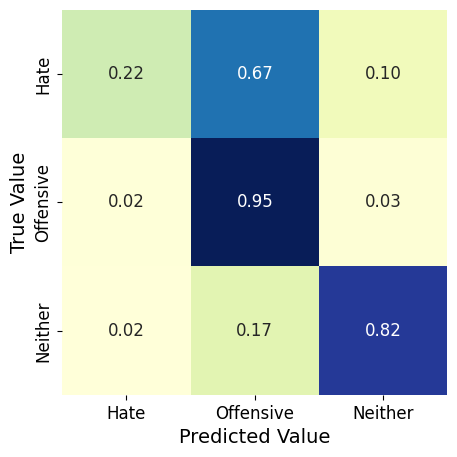

In [22]:
#Confusion Matrix for TFIDF with additional features
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)


In [23]:
!pip install gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing i

In [24]:
pip install kaleido


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.1 MB/s eta 0:00:00


In [25]:
pip install typing-extensions


In [26]:
import gradio as gr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Define preprocess_new_tweet function
def preprocess_new_tweet(tweet):
    # Implement your preprocessing steps here
    return tweet

# Assuming you have the tfidf_vectorizer and dataset already prepared
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(dataset['tweet'])

X = tfidf
y = dataset['class'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support = LinearSVC(random_state=20)
support.fit(X_train_tfidf, y_train)
y_preds = support.predict(X_test_tfidf)
acc1 = accuracy_score(y_test, y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("SVM, Accuracy Score:", acc1)

# Define a function to predict the class of a new tweet
def predict_class(new_tweet):
    try:
        processed_new_tweet = preprocess_new_tweet(new_tweet)
        new_tweet_tfidf = tfidf_vectorizer.transform([processed_new_tweet])
        predicted_class = support.predict(new_tweet_tfidf)
        if predicted_class[0] == 0:
            return f"Hateful content detected in your content (Class {predicted_class[0]}). Please review it before posting!!", "<a href='http://wycliffe.pythonanywhere.com/posts'>Go back home</a>"
        elif predicted_class[0] == 1:
            return f"Your content contains some offensive words (Class {predicted_class[0]}). Please review it before posting!!", "<a href='http://wycliffe.pythonanywhere.com/posts'>Go back home</a>"
        elif predicted_class[0] == 2:
            return f"You have an online-friendly content (Class {predicted_class[0]}). Feel free to post it", "<a href='http://wycliffe.pythonanywhere.com/posts'>Go back home</a>"
    except Exception as e:
        return f"An error occurred: {str(e)}", "<a href='http://wycliffe.pythonanywhere.com/posts'>Go back home</a>"

iface = gr.Interface(
    fn=predict_class,
    inputs="text",
    outputs=["text", "html"],
    title="Hate Speech Detection",
    description="Enter a tweet to predict its class: 0 for hatespeech, 1 for offensive language, 2 for neither.",
    examples=[
        ["Let's make a better online society"]
    ]
)

# Launch the interface
iface.launch()


              precision    recall  f1-score   support

           0       0.48      0.21      0.30       290
           1       0.92      0.95      0.94      3832
           2       0.82      0.84      0.83       835

    accuracy                           0.89      4957
   macro avg       0.74      0.67      0.69      4957
weighted avg       0.88      0.89      0.88      4957

SVM, Accuracy Score: 0.8912648779503732
Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://a653355bc5051ca789.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
